In [1]:
import os
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import torch
from torch import nn, optim
from sklearn.metrics import mean_squared_error

In [2]:
LOCAL_CSV = "/kaggle/input/wind-speed-prediction-dataset/wind_dataset.csv"
df = pd.read_csv(LOCAL_CSV)

In [3]:
df.sort_values("DATE", inplace=True)
df.reset_index(drop=True, inplace=True)

# Inspect first few rows
print("First 5 rows of raw data:")
print(df.head())

First 5 rows of raw data:
         DATE   WIND  IND  RAIN  IND.1  T.MAX  IND.2  T.MIN  T.MIN.G
0  1961-01-01  13.67    0   0.2    0.0    9.5    0.0    3.7     -1.0
1  1961-01-02  11.50    0   5.1    0.0    7.2    0.0    4.2      1.1
2  1961-01-03  11.25    0   0.4    0.0    5.5    0.0    0.5     -0.5
3  1961-01-04   8.63    0   0.2    0.0    5.6    0.0    0.4     -3.2
4  1961-01-05  11.92    0  10.4    0.0    7.2    1.0   -1.5     -7.5


In [4]:
n_before = len(df)
df_clean = df.dropna(subset=["T.MIN"]).copy()
n_after = len(df_clean)
print(f"Dropped {n_before - n_after} rows due to missing T.MIN. Remaining rows: {n_after}\n")

Dropped 674 rows due to missing T.MIN. Remaining rows: 5900



In [5]:
series = df_clean["T.MIN"].values.astype(np.float32)
dates = df_clean["DATE"].values  # just for plotting if desired

# 2) Build rolling-window sequences: past 7 days → next day
def create_sequences(data_array, window_size=7):
    """
    Given a 1D numpy array `data_array`, returns:
      - X: (num_samples, window_size)
      - y: (num_samples,)
    Each sample uses data_array[i : i+window_size] → target data_array[i+window_size].
    """
    X, y = [], []
    for i in range(len(data_array) - window_size):
        X.append(data_array[i : i + window_size])
        y.append(data_array[i + window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 7
X_all, y_all = create_sequences(series, WINDOW_SIZE)
print(f"Total sequences from full series (each length {WINDOW_SIZE}): {X_all.shape[0]}\n")

# 3) Train/test split (80% train, 20% test)
num_sequences = X_all.shape[0]
split_idx = int(0.8 * num_sequences)

# Initial train inputs/targets
X_train_initial = X_all[:split_idx]       # shape: (split_idx, 7)
y_train_initial = y_all[:split_idx]       # shape: (split_idx,)

# The “test” will simulate streaming one day at a time:
#   - test_series_data[i] is the true T.MIN for that day,
#   - but initial model never saw it. We’ll feed it in one by one.
test_series_data = series[ split_idx + WINDOW_SIZE : ]  # from series index (split_idx + 7) onward
test_series_dates = dates[ split_idx + WINDOW_SIZE : ]

print(f"  ➔ Initial training samples: {X_train_initial.shape[0]}")
print(f"  ➔ Testing (stream) samples: {len(test_series_data)}\n")

# 4) Convert initial train to PyTorch tensors
X_train_t = torch.from_numpy(X_train_initial)                   # shape: (num_train, 7)
y_train_t = torch.from_numpy(y_train_initial).unsqueeze(1)      # shape: (num_train, 1)

Total sequences from full series (each length 7): 5893

  ➔ Initial training samples: 4714
  ➔ Testing (stream) samples: 1179



In [6]:
X_test_final = X_all[split_idx:]
y_test_final = y_all[split_idx:]
X_test_t = torch.from_numpy(X_test_final)
y_test = y_test_final  # Keep as numpy for RMSE

In [7]:
class SimpleKAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleKAN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [8]:
# Hyperparameters
INPUT_DIM  = WINDOW_SIZE      # 7
HIDDEN_DIM = 64
OUTPUT_DIM = 1
LR = 1e-3
INITIAL_EPOCHS = 50
RETRAIN_EPOCHS = 10
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleKAN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

Using device: cpu


In [9]:
# Utility to create mini-batches
def get_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i : i + batch_size], y[i : i + batch_size]

>>> Training initial model on first 80% of data ...
  Epoch  1/50  —  Train MSE: 10.0695
  Epoch 10/50  —  Train MSE: 7.6474
  Epoch 20/50  —  Train MSE: 7.5846
  Epoch 30/50  —  Train MSE: 7.5034
  Epoch 40/50  —  Train MSE: 7.5276
  Epoch 50/50  —  Train MSE: 7.4333


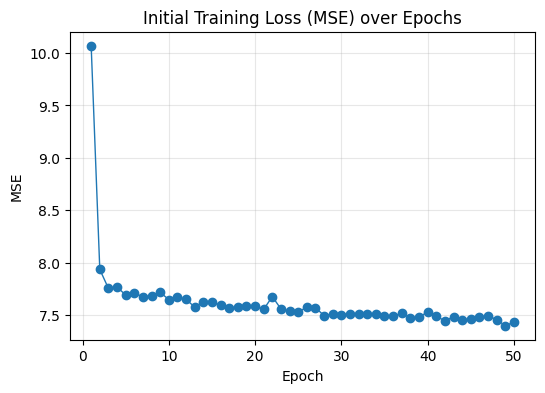

In [10]:
print(">>> Training initial model on first 80% of data ...")
model.train()
initial_train_losses = []

for epoch in range(1, INITIAL_EPOCHS + 1):
    epoch_losses = []
    # Shuffle at each epoch
    perm = torch.randperm(X_train_t.size(0))
    X_shuf = X_train_t[perm]
    y_shuf = y_train_t[perm]
    
    for X_batch, y_batch in get_batches(X_shuf, y_shuf, BATCH_SIZE):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    avg_loss = np.mean(epoch_losses)
    initial_train_losses.append(avg_loss)
    if epoch % 10 == 0 or epoch == 1:
        print(f"  Epoch {epoch:>2d}/{INITIAL_EPOCHS}  —  Train MSE: {avg_loss:.4f}")

# Plot initial training loss curve
plt.figure(figsize=(6,4))
plt.plot(range(1, INITIAL_EPOCHS+1), initial_train_losses, marker="o", linewidth=1)
plt.title("Initial Training Loss (MSE) over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(alpha=0.3)
plt.show()

In [11]:
def evaluate_and_plot(model, X_test_t, y_test, title_suffix=""):
    model.eval()
    with torch.no_grad():
        X_test_dev = X_test_t.to(device)
        y_pred_test = model(X_test_dev).cpu().numpy().flatten()
        y_true_test = y_test

    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    print(f"\nFinal Test RMSE{title_suffix}: {rmse_test:.4f} (°C)")

    n_display = 10
    print(f"\nSample predictions vs. actual (last {n_display} test points){title_suffix}:")
    for i in range(-n_display, 0):
        pred = y_pred_test[i]
        true = y_true_test[i]
        print(f"  Pred = {pred:6.2f} °C   ––   Actual = {true:6.2f} °C")

    plt.figure(figsize=(8,4))
    idx_start = max(0, len(y_true_test) - 100)
    x_axis = range(idx_start, len(y_true_test))
    plt.plot(x_axis, y_true_test[idx_start:], label="Actual", linewidth=1)
    plt.plot(x_axis, y_pred_test[idx_start:], label="Predicted", linewidth=1)
    plt.title(f"Last 100 Test Points: T.MIN Actual vs. Predicted{title_suffix}")
    plt.xlabel("Sample index")
    plt.ylabel("T.MIN (°C)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


Final Test RMSE (after initial training): 2.6489 (°C)

Sample predictions vs. actual (last 10 test points) (after initial training):
  Pred =  -1.01 °C   ––   Actual =  -2.10 °C
  Pred =  -0.20 °C   ––   Actual =  -1.70 °C
  Pred =   0.13 °C   ––   Actual =   4.30 °C
  Pred =   3.62 °C   ––   Actual =   3.30 °C
  Pred =   3.41 °C   ––   Actual =   2.30 °C
  Pred =   3.42 °C   ––   Actual =   4.00 °C
  Pred =   3.66 °C   ––   Actual =   8.50 °C
  Pred =   6.61 °C   ––   Actual =   3.50 °C
  Pred =   3.81 °C   ––   Actual =   0.30 °C
  Pred =   1.29 °C   ––   Actual =  -1.50 °C


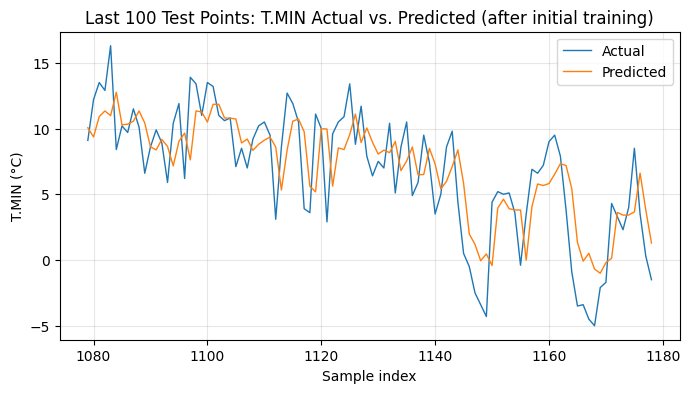

In [12]:
evaluate_and_plot(model, X_test_t, y_test, title_suffix=" (after initial training)")

In [13]:
train_series_end = split_idx + WINDOW_SIZE
all_series = list(series[:train_series_end])  # will keep appending as we “observe” new days

# Keep track of predictions and ground truth for every test day
predictions = []
actuals     = []
prediction_dates = []

# Choose how often to retrain (e.g. every 20 days in the test stream)
RETRAIN_INTERVAL = 20

print("\n>>> Beginning self-improvement over test set ...")
model.eval()

# We’ll reuse the same optimizer and model weights, but each retraining will run for fewer epochs
for step, true_val in enumerate(test_series_data):
    # 1) Build input window: last WINDOW_SIZE days from all_series
    window_input = np.array(all_series[-WINDOW_SIZE:], dtype=np.float32).reshape(1, -1)  # shape (1,7)
    X_input_t = torch.from_numpy(window_input).to(device)
    
    # 2) Predict, record prediction vs. true value
    with torch.no_grad():
        y_hat = model(X_input_t).cpu().item()
    predictions.append(y_hat)
    actuals.append(float(true_val))
    prediction_dates.append(test_series_dates[step])
    
    # Print occasional progress
    if (step + 1) % 50 == 0 or step == 0:
        print(f"  Stream day {step+1}/{len(test_series_data)} — Pred = {y_hat:.2f}, True = {true_val:.2f}")
    
    # 3) Append the true value to all_series so future windows include this day
    all_series.append(float(true_val))
    
    # 4) If we have seen RETRAIN_INTERVAL new days, trigger a retraining
    if (step + 1) % RETRAIN_INTERVAL == 0:
        print(f"\n  ====> Retraining on all seen data at stream-step {step+1} ...")
        # Rebuild sequences from scratch using all_series
        all_series_array = np.array(all_series, dtype=np.float32)
        X_new, y_new = create_sequences(all_series_array, WINDOW_SIZE)
        
        # We only want to train on the “supervised” windows up to the point where
        # sequences stop being full. Because all_series grew by one element for each test day,
        # X_new & y_new now contain additional examples beyond our original split.
        
        # Convert to Torch tensors
        X_new_t = torch.from_numpy(X_new)
        y_new_t = torch.from_numpy(y_new).unsqueeze(1)
        
        # Prepare a new optimizer so we can continue training from current weights
        # (Alternatively, you could re-initialize the model. Here we continue from existing.)
        optimizer = optim.Adam(model.parameters(), lr=LR)
        
        model.train()
        for ep in range(1, RETRAIN_EPOCHS + 1):
            epoch_losses = []
            # Shuffle new full training set each epoch
            perm = torch.randperm(X_new_t.size(0))
            X_shuf = X_new_t[perm]
            y_shuf = y_new_t[perm]
            
            for Xb, yb in get_batches(X_shuf, y_shuf, BATCH_SIZE):
                Xb = Xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                outb = model(Xb)
                lossb = criterion(outb, yb)
                lossb.backward()
                optimizer.step()
                epoch_losses.append(lossb.item())
            avg_l = np.mean(epoch_losses)
            if ep == 1 or ep == RETRAIN_EPOCHS:
                print(f"     • Retrain Epoch {ep}/{RETRAIN_EPOCHS}  —  MSE: {avg_l:.4f}")
        model.eval()
        print(f"  <==== Retraining complete.\n")


>>> Beginning self-improvement over test set ...
  Stream day 1/1179 — Pred = 9.85, True = 9.60

  ====> Retraining on all seen data at stream-step 20 ...
     • Retrain Epoch 1/10  —  MSE: 7.4664
     • Retrain Epoch 10/10  —  MSE: 7.4176
  <==== Retraining complete.


  ====> Retraining on all seen data at stream-step 40 ...
     • Retrain Epoch 1/10  —  MSE: 7.4977
     • Retrain Epoch 10/10  —  MSE: 7.4228
  <==== Retraining complete.

  Stream day 50/1179 — Pred = 3.69, True = 6.70

  ====> Retraining on all seen data at stream-step 60 ...
     • Retrain Epoch 1/10  —  MSE: 7.4581
     • Retrain Epoch 10/10  —  MSE: 7.4371
  <==== Retraining complete.


  ====> Retraining on all seen data at stream-step 80 ...
     • Retrain Epoch 1/10  —  MSE: 7.4021
     • Retrain Epoch 10/10  —  MSE: 7.3762
  <==== Retraining complete.

  Stream day 100/1179 — Pred = 8.48, True = 6.20

  ====> Retraining on all seen data at stream-step 100 ...
     • Retrain Epoch 1/10  —  MSE: 7.3830
     • R


=== Final Test‐stream RMSE after self-improvement: 2.6994 °C ===



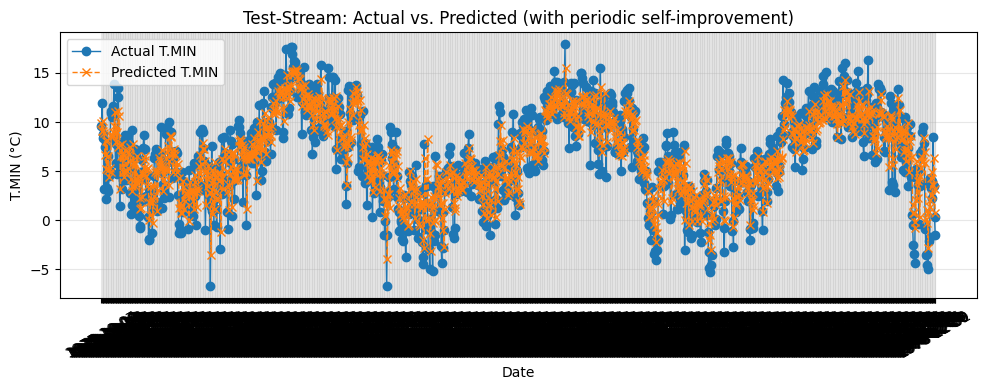

In [14]:
preds = np.array(predictions)
trues = np.array(actuals)
overall_rmse = np.sqrt(mean_squared_error(trues, preds))
print(f"\n=== Final Test‐stream RMSE after self-improvement: {overall_rmse:.4f} °C ===\n")

# 9) Plot predicted vs. actual for the test stream
plt.figure(figsize=(10,4))
plt.plot(prediction_dates, trues, marker="o", linestyle="-", linewidth=1, label="Actual T.MIN")
plt.plot(prediction_dates, preds, marker="x", linestyle="--", linewidth=1, label="Predicted T.MIN")
plt.xlabel("Date")
plt.ylabel("T.MIN (°C)")
plt.title("Test‐Stream: Actual vs. Predicted (with periodic self-improvement)")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Final Test RMSE (after retraining): 2.5501 (°C)

Sample predictions vs. actual (last 10 test points) (after retraining):
  Pred =   0.89 °C   ––   Actual =  -2.10 °C
  Pred =   2.11 °C   ––   Actual =  -1.70 °C
  Pred =   1.32 °C   ––   Actual =   4.30 °C
  Pred =   4.32 °C   ––   Actual =   3.30 °C
  Pred =   4.94 °C   ––   Actual =   2.30 °C
  Pred =   2.54 °C   ––   Actual =   4.00 °C
  Pred =   3.57 °C   ––   Actual =   8.50 °C
  Pred =   6.32 °C   ––   Actual =   3.50 °C
  Pred =   3.22 °C   ––   Actual =   0.30 °C
  Pred =   0.72 °C   ––   Actual =  -1.50 °C


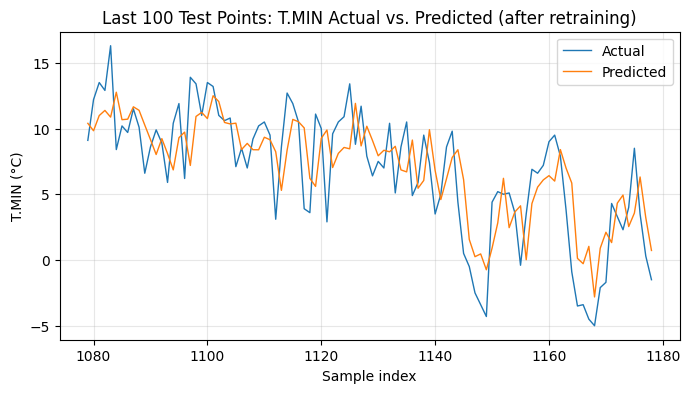

In [15]:
evaluate_and_plot(model, X_test_t, y_test, title_suffix=" (after retraining)")